# Predicting Activity with a Multilayer Perceptron

... i.e., time-independent model, full dataset

In [1]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# fix random seed for reproducibility
seed = 66
numpy.random.seed(seed)

data = pandas.read_csv("../data/processed/train.csv")
notnull_data = data[data.notnull().all(axis=1)]
train = notnull_data.values
data2 = pandas.read_csv("../data/processed/test.csv")
notnull_data2 = data2[data2.notnull().all(axis=1)]
test = notnull_data2.values

Using Theano backend.


In [2]:
X_train = train[:,3:7558].astype(float)
#X_train = train[:,3:13].astype(float)
Y_train = train[:,7558]
X_test = test[:,3:7558].astype(float)
#X_test = test[:,3:13].astype(float)
Y_test = test[:,7558]

# One hot encoding of the response variable (using dummy variables)
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_Y_train = encoder.transform(Y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = to_categorical(encoded_Y_train)
encoder.fit(Y_test)
encoded_Y_test = encoder.transform(Y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = to_categorical(encoded_Y_test)

# Sanity check on matrix dimensions, after droppinig null/nans
#print X_train.shape #(4472, 7555)
#print Y_test.shape #(1044, )
#print dummy_y_test.shape # (1044, 5)


In [3]:
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.optimizers import SGD

# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=7555, init='uniform', activation='tanh', W_constraint=maxnorm(4)))
    model.add(Dense(20, init='uniform', activation='tanh', W_constraint=maxnorm(4)))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Apply dropout regularization, it is overfitting!
def create_dropout():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(7555,)))
    model.add(Dense(200, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Apply dropout regularization, it is overfitting!
def create_dropout_decay():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(7555,)))
    model.add(Dense(200, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.0005, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# evaluate baseline model with standardized dataset
numpy.random.seed(seed)
#estimators = []
#estimators.append(('standardize', StandardScaler()))
#estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, nb_epoch=10, batch_size=10, verbose=1)))
# We define a pipeline of estimators, in which first the scaler is fitted to the data, then the MLP is applied
#pipeline = Pipeline(estimators)
#kfold = StratifiedKFold(y=Y_train, n_folds=3, shuffle=True, random_state=seed)

#model = create_baseline()
model = create_dropout_decay()
# We standardize on the basis of the training data
scaler = StandardScaler().fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

Epoch 00000: val_acc improved from -inf to 0.36782, saving model to weights.best.hdf5
Epoch 00001: val_acc did not improve
Epoch 00002: val_acc improved from 0.36782 to 0.43199, saving model to weights.best.hdf5
Epoch 00003: val_acc improved from 0.43199 to 0.45785, saving model to weights.best.hdf5
Epoch 00004: val_acc did not improve
Epoch 00005: val_acc improved from 0.45785 to 0.46073, saving model to weights.best.hdf5
Epoch 00006: val_acc did not improve
Epoch 00007: val_acc did not improve
Epoch 00008: val_acc did not improve
Epoch 00009: val_acc improved from 0.46073 to 0.46743, saving model to weights.best.hdf5
Epoch 00010: val_acc did not improve
Epoch 00011: val_acc did not improve
Epoch 00012: val_acc did not improve
Epoch 00013: val_acc did not improve
Epoch 00014: val_acc improved from 0.46743 to 0.47414, saving model to weights.best.hdf5
Epoch 00015: val_acc did not improve
Epoch 00016: val_acc did not improve
Epoch 00017: val_acc did not improve
Epoch 00018: val_acc did 

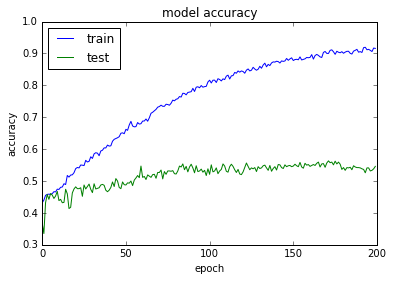

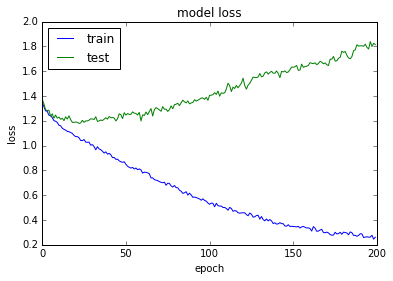

In [4]:
from keras.callbacks import ModelCheckpoint

# To save the best model
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
filepath="weights.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the model
history = model.fit(X_train_st, dummy_y_train, 
                    validation_data=(X_test_st,dummy_y_test), 
                    nb_epoch=200, batch_size=10, verbose=0, 
                    callbacks=callbacks_list)
#results = cross_val_score(pipeline, X_train, dummy_y_train, cv=kfold)
#print("Standardized data Acc (in CV training data): %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# evaluate the model
#scores = pipeline.evaluate(X_test, dummy_y_test)
#print pipeline.metrics_names[1]
#print scores[1]*100
# For other metrics, see http://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

# Other performance/accuracy metrics
Y_pred = model.predict(X_test_st)
print Y_pred.shape

# Accuracy
print('Accuracy:')
print(accuracy_score(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1)))


# Confusion matrix
cm = confusion_matrix(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1))
numpy.set_printoptions(precision=2)
print('Confusion matrix:')
print(cm)

# AUC
roc = roc_auc_score(dummy_y_test, Y_pred, average='macro')
print('AUC score:')
print(roc)
    

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()



## MLPs using PCA as inputs

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
PCAtrain = pca.fit_transform(X_train_st)
PCAtest = pca.transform(X_test_st)

print 'Variance explained:'
print pca.explained_variance_ratio_
print 'Total variance explained by 20 components:'
print sum(pca.explained_variance_ratio_)
#print PCAtrain.shape
#print PCAtest.shape

Variance explained:
[ 0.2   0.08  0.04  0.02  0.02  0.02  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
Total variance explained by 20 components:
0.630815671837


In [6]:
# Apply dropout regularization, it is overfitting!
def create_dropout_decay_PCA():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(100,)))
    model.add(Dense(200, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.0005, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

model = create_dropout_decay_PCA()

# To save the best model
# serialize model to JSON
model_json = model.to_json()
with open("modelpca.json", "w") as json_file:
    json_file.write(model_json)
filepath="weightspca.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]



Epoch 00000: val_acc improved from -inf to 0.40326, saving model to weightspca.best.hdf5
Epoch 00001: val_acc improved from 0.40326 to 0.44444, saving model to weightspca.best.hdf5
Epoch 00002: val_acc improved from 0.44444 to 0.44828, saving model to weightspca.best.hdf5
Epoch 00003: val_acc did not improve
Epoch 00004: val_acc improved from 0.44828 to 0.46552, saving model to weightspca.best.hdf5
Epoch 00005: val_acc improved from 0.46552 to 0.47510, saving model to weightspca.best.hdf5
Epoch 00006: val_acc did not improve
Epoch 00007: val_acc did not improve
Epoch 00008: val_acc did not improve
Epoch 00009: val_acc did not improve
Epoch 00010: val_acc improved from 0.47510 to 0.48467, saving model to weightspca.best.hdf5
Epoch 00011: val_acc did not improve
Epoch 00012: val_acc did not improve
Epoch 00013: val_acc did not improve
Epoch 00014: val_acc did not improve
Epoch 00015: val_acc did not improve
Epoch 00016: val_acc did not improve
Epoch 00017: val_acc did not improve
Epoch 0

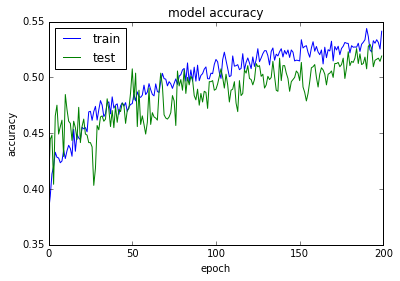

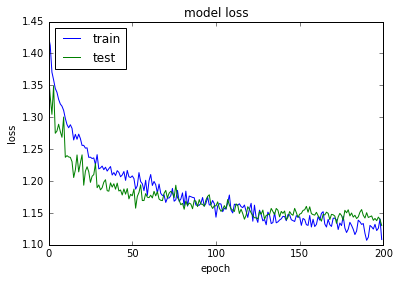

In [7]:
# Fit the model
history = model.fit(PCAtrain, dummy_y_train, 
                    validation_data=(PCAtest,dummy_y_test), 
                    nb_epoch=200, batch_size=10, verbose=0, 
                    callbacks=callbacks_list)

# Other performance/accuracy metrics
Y_pred = model.predict(PCAtest)
print Y_pred.shape

# Accuracy
print('Accuracy:')
print(accuracy_score(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1)))


# Confusion matrix
cm = confusion_matrix(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1))
numpy.set_printoptions(precision=2)
print('Confusion matrix:')
print(cm)

# AUC
roc = roc_auc_score(dummy_y_test, Y_pred, average='macro')
print('AUC score:')
print(roc)
    

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()